In [ ]:
# Mount on drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/UDL Mini Project

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/UDL Mini Project


In [ ]:
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import datasets, transforms
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
import heapq
import copy
import json
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cpu


# 1. Input Processing

## 1.1 Load all the training and testing sets

In [ ]:
def get_mnist_data(batch_train=64, batch_eval=256, root='./data'):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train = datasets.MNIST(root=root, train=True, download=True, transform=transform)
    test  = datasets.MNIST(root=root, train=False, download=True, transform=transform)

    train_loader_full = DataLoader(train, batch_size=batch_train, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test, batch_size=batch_eval, shuffle=False, num_workers=2, pin_memory=True)
    return train, train_loader_full, test, test_loader

train_dataset, train_loader_full, test_dataset, test_loader = get_mnist_data()

## 1.2 Take out subsets of training data

In [ ]:
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed = 0
set_seed(seed)

In [ ]:
def sample_balanced_seed(full_dataset: Dataset, n_per_class=2, num_classes=10, seed=0):
  
    set_seed(seed)
    indices_by_class = defaultdict(list)
    for idx, (_, label) in enumerate(full_dataset):
        indices_by_class[int(label)].append(idx)
    seed_indices = []
    for c in range(num_classes):
        choices = random.sample(indices_by_class[c], k=n_per_class)
        seed_indices.extend(choices)
    random.shuffle(seed_indices)
    return seed_indices 

In [ ]:
# Take out 20 images, 2 per class
seed_idx = sample_balanced_seed(train_dataset, n_per_class=2, seed=seed)
train_dataset_small = Subset(train_dataset, seed_idx)
train_loader_small = DataLoader(train_dataset_small, batch_size=64, shuffle=True)
print(len(train_dataset_small))

20


## 1.3 Create Dataset for Rotation Prediction SSL

In [ ]:
class RotDataset(Dataset):
    """
    Given an underlying dataset that returns (x, y) (y ignored),
    produce 4 rotated versions per image with rotation label 0..3.
    x expected as tensor [1,H,W] already normalized.
    """
    def __init__(self, base_dataset, transform=None):
        self.base = base_dataset
        # rotation transforms: 0,90,180,270
        self.rots = [lambda x: x,
                     lambda x: torch.rot90(x, 1, dims=[-2,-1]),
                     lambda x: torch.rot90(x, 2, dims=[-2,-1]),
                     lambda x: torch.rot90(x, 3, dims=[-2,-1])]
        self.transform = transform

    def __len__(self):
        return len(self.base) * 4

    def __getitem__(self, idx):
        base_idx = idx // 4
        rot_idx = idx % 4
        x, _ = self.base[base_idx]
        x_rot = self.rots[rot_idx](x)
        if self.transform:
            x_rot = self.transform(x_rot)
        return x_rot, rot_idx

# 2. Model for BNN Analytical

## 2.1 BNN Model Architecture (Extended with Non-Zero mean Prior)

In [ ]:

def stable_inv(mat, jitter=1e-6):
    """
    Numerically stable inverse: try Cholesky, fall back to adding jitter.
    mat: symmetric (d x d) torch tensor
    """
    try:
        L = torch.linalg.cholesky(mat, upper=False)
        invL = torch.inverse(L)
        inv = invL.t() @ invL
        return inv
    except Exception:
        d = mat.shape[0]
        mat_j = mat + jitter * torch.eye(d, device=mat.device, dtype=mat.dtype)
        return torch.inverse(mat_j)

In [ ]:
class MLPRegressor(nn.Module):
    
    def __init__(self, input_dim=28*28, hidden_sizes=[512,256], output_dim=10, dropout=0.5, device='cpu'):
        super().__init__()
        self.device = device
        layers = []
        in_dim = input_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU(inplace=True))
            if dropout and dropout > 0:
                layers.append(nn.Dropout(p=dropout))
            in_dim = h
        self.feature_extractor = nn.Sequential(*layers)
        self.head = nn.Linear(in_dim, output_dim)

        # Bayes posterior storage (populated by fit_last_layer_posterior)
        self.posterior = None  # dict with keys 'U_post', 'M', 'Sigma', 's'
        self._init_weights()
        self.to(self.device)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # small Gaussian init (close to older frameworks), reasonable for regression
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)

    def forward(self, x, return_features=False, use_bayesian=False, n_samples=0):
       
        if x.dim() == 4:
            x_flat = x.view(x.size(0), -1)
        else:
            x_flat = x

        features = self.feature_extractor(x_flat)  # [B, K]

        if use_bayesian:
            if self.posterior is None:
                raise RuntimeError("Posterior not set. Call model.fit_last_layer_posterior(Phi, Y, ...) first.")

            # Obtain analytic predictive mean mu, and covariance (1+q)Sigma as a tuple (mu, q, Sigma)
            preds_tuple = self.predict_last_layer_bayes_from_features(features)

            if n_samples is None or n_samples == 0:
                if return_features:
                    return preds_tuple, features
                return preds_tuple
            else:
                raise RuntimeError("Not considering sampling posterior yet...")
         

        # default deterministic forward (head weights used directly)
        preds = self.head(features)
        if return_features:
            return preds, features
        return preds

    def get_features_from_loader(self, loader):
        """
        Helper: pass a DataLoader returning (x,y) and get stacked features and labels.
        Returns:
          feats (N, K) torch tensor on cpu
          Y_onehot (N, C) torch tensor on cpu
        """
        self.eval()
        feats_list = []
        y_list = []
        with torch.no_grad():
            for x, y in loader:
                x = x.to(self.device)
                logits, feats = self.forward(x, return_features=True, use_bayesian=False)
                feats_list.append(feats.cpu())
                y_list.append(F.one_hot(y, num_classes=logits.size(1)).float())
        feats = torch.cat(feats_list, dim=0)
        Y = torch.cat(y_list, dim=0)
        return feats, Y

    def fit_last_layer_posterior(self, Phi, Y, s=1.0, Sigma=None, M0=None, jitter=1e-6):
        
        device = self.device
        Phi = Phi.to(device)
        Y = Y.to(device)
        N, K = Phi.shape
        _, C = Y.shape

        if Sigma is None:
            # MAP ridge to estimate residuals
            A_map = Phi.t() @ Phi + s * torch.eye(K, device=device)
            Ainv_map = stable_inv(A_map)
            W_map = Ainv_map @ (Phi.t() @ Y)
            Resid = Y - Phi @ W_map
            Sigma_emp = (Resid.t() @ Resid) / max(N - 1, 1)
            Sigma = Sigma_emp + 1e-6 * torch.eye(C, device=device)
        else:
            Sigma = Sigma.to(device)

        S_mat = s * torch.eye(K, device=device)
        A = S_mat + Phi.t() @ Phi  # (K,K)
        U_post = stable_inv(A)     # (K,K)

        if M0 is None:
            M = U_post @ (Phi.t() @ Y) # (K,C)
        else:
            print("Using Pretrained Prior Weight M0!")
            M0 = M0.to(device)
            assert M0.shape == (K, C)
            M = U_post @ (s * M0 + Phi.t() @ Y)

        self.posterior = {
            'U_post': U_post,
            'M': M,
            'Sigma': Sigma,
            's': s,
        }
        return self.posterior


    def predict_last_layer_bayes_from_features(self, feats):
       
        if self.posterior is None:
            raise RuntimeError("Posterior not fit. Call fit_last_layer_posterior first.")
        feats = feats.to(self.device)
        U_post = self.posterior['U_post'].to(self.device)
        M = self.posterior['M'].to(self.device)
        Sigma = self.posterior['Sigma'].to(self.device)

        means = feats @ M                             # (B, C)
        temp = (U_post @ feats.t()).t()               # (B, K)
        q = (feats * temp).sum(dim=1)                 # (B,)
        return means, q, Sigma

    def sample_W_from_posterior(self, n_samples=1, jitter=1e-8):
       
        if self.posterior is None:
            raise RuntimeError("Posterior not fit. Call fit_last_layer_posterior first.")
        M = self.posterior['M'].to(self.device)       # (K, C)
        U_post = self.posterior['U_post'].to(self.device)
        Sigma = self.posterior['Sigma'].to(self.device)
        K, C = M.shape

        # Cholesky factors
        try:
            A = torch.cholesky(U_post, upper=False)
        except Exception:
            A = torch.cholesky(U_post + jitter * torch.eye(K, device=self.device), upper=False)
        try:
            B = torch.cholesky(Sigma, upper=False)
        except Exception:
            B = torch.cholesky(Sigma + jitter * torch.eye(C, device=self.device), upper=False)

        samples = []
        for _ in range(n_samples):
            Z = torch.randn((K, C), device=self.device)
            W_s = M + A @ Z @ B.t()   # (K, C)
            samples.append(W_s.unsqueeze(0))
        W_samples = torch.cat(samples, dim=0)
        return W_samples  # (n_samples, K, C)

    def freeze_features(self):
        for p in self.feature_extractor.parameters():
            p.requires_grad = False

    def unfreeze_features(self):
        for p in self.feature_extractor.parameters():
            p.requires_grad = True

## 2.2 Model SSL Pretraining

In [ ]:
#@title Rotation Prediction Pretraining
def ssl_rotation_pretrain(model: MLPRegressor,
                          base_dataset,
                          device='cpu',
                          batch_size=128,
                          epochs=20,
                          lr=1e-3,
                          weight_decay=1e-4):

    model.to(device)
    model.train()
    # Wrap base dataset into rotated dataset
    rot_ds = RotDataset(base_dataset)
    loader = DataLoader(rot_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    # create temporary rotation head
    # find feature dim K via a dummy forward
    with torch.no_grad():
        model.eval()
        x0, _ = base_dataset[0]
        x0 = x0.unsqueeze(0)
        _, feats = model.forward(x0.to(device), return_features=True, use_bayesian=False)
        K = feats.size(1)
    rot_head = nn.Linear(K, 4).to(device)
    opt = torch.optim.Adam(list(model.feature_extractor.parameters()) + list(rot_head.parameters()),
                           lr=lr, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        rot_head.train()
        running = 0.0
        for x, rot_label in loader:
            x = x.to(device)
            rot_label = rot_label.to(device)
            opt.zero_grad()
            _, feats = model.forward(x, return_features=True, use_bayesian=False)
            logits = rot_head(feats)
            loss = loss_fn(logits, rot_label)
            loss.backward()
            opt.step()
            running += loss.item() * x.size(0)
        print(f"[SSL epoch {epoch+1}/{epochs}] loss={(running/len(loader.dataset)):.4f}")
    # done: keep feature_extractor weights (head dropped)
    return model

In [ ]:
#@title Compute W_SSL for Final Layer Weights via Ridge Linear Regression
def compute_W_ssl_from_labeled(model: MLPRegressor, labeled_loader: DataLoader, alpha=1e-3, device='cpu'):
  
    model.eval()
    Phi, Y = model.get_features_from_loader(labeled_loader)   # returns on CPU
    Phi = Phi.to(device)   # (N, K)
    Y = Y.to(device)       # (N, C)
    N, K = Phi.shape
    _, C = Y.shape
    # Ridge: compute (K,K)
    A = Phi.t() @ Phi + alpha * torch.eye(K, device=device)
    Ainv = torch.inverse(A)
    W_ssl = Ainv @ (Phi.t() @ Y)   # (K, C)
    return W_ssl.cpu()  # return on CPU for storage; you can move to device later


# 3. Training & Evaluation

In [ ]:
def one_hot(labels, num_classes=10, device='cpu', dtype=torch.float32):
    return F.one_hot(labels.long(), num_classes=num_classes).to(dtype=dtype).to(device)

## 3.1 Training for one Epoch

In [ ]:
# -------------------------
# Training loop (MSE / regression to one-hot)
# -------------------------
def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    running_loss = 0.0
    total_samples = 0
    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)
        y_onehot = one_hot(y, num_classes=10, device=device)
        optimizer.zero_grad()
        outputs = model(x)  # shape [B,10]
        loss = F.mse_loss(outputs, y_onehot, reduction='mean')  # mean over batch and outputs
        loss.backward()
        optimizer.step()
        batch_size = x.size(0)
        running_loss += loss.item() * batch_size
        total_samples += batch_size
    return running_loss / total_samples


## 3.2 Evaluation Functions

In [ ]:
# -------------------------
# infer model last layer posterior for Bayesian evaluation
# -------------------------
@torch.no_grad()
def infer_model_posterior(model, labeled_loader, s=1.0, Sigma=None, M0=None, device='cpu'):
    model.freeze_features()

    Phi, Y = model.get_features_from_loader(labeled_loader)  # returns on CPU; move to device if needed
    Phi = Phi.to(model.device)
    Y = Y.to(model.device)

    posterior = model.fit_last_layer_posterior(Phi, Y, s=s, Sigma=Sigma, M0=M0)
    #print("Posterior:", posterior)
    print("M_post shape", posterior["M"].shape)
    print("U_post shape", posterior["U_post"].shape)
    print("Sigma shape", posterior["Sigma"].shape)
    return posterior


@torch.no_grad()
def evaluate_rmse(model, dataloader, use_bayesian=False, device='cpu'):
    """
    Compute RMSE between model outputs (R^10) and one-hot targets.
    if use_bayesian:
        call model forward with use_bayesian=True to obtain preds_tuple
        then use pred_mean to compute RMSE
    else:
        directly obtain point estimate output vector to compute RMSE
    RMSE is sqrt(mean((y_pred - y_onehot)^2)) averaged over all samples and output dimensions.
    Returns scalar RMSE.
    """
    model.eval()
    sqerr_sum = 0.0
    total = 0
    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)
        y_onehot = one_hot(y, num_classes=10, device=device)

        if use_bayesian:
            preds_tuple = model.forward(x, use_bayesian=True, n_samples=0)
            outputs = preds_tuple[0] 
        else:
            outputs = model.forward(x, use_bayesian=False)  # [B,10]

        sqerr = (outputs - y_onehot).pow(2).sum().item() 
        sqerr_sum += sqerr
        total += x.size(0) * 10 
    mse = sqerr_sum / total
    rmse = np.sqrt(mse)
    return rmse

## 3.3 Training Loop

In [ ]:
train_dataset, train_loader, test_dataset, test_loader = get_mnist_data(batch_train=128, batch_eval=256)
# Subsample labelled data
seed_idx = sample_balanced_seed(train_dataset, n_per_class=100, seed=seed)
labeled_dataset = Subset(train_dataset, seed_idx)
labeled_loader = DataLoader(labeled_dataset, batch_size=64, shuffle=True)
print("Labeled set size:", len(labeled_dataset))

Labeled set size: 1000


In [ ]:

def pretrain_model(seed, hidden_sizes):
    set_seed(seed)
    model = MLPRegressor(input_dim=28*28, hidden_sizes=hidden_sizes, output_dim=10, dropout=0.5, device=device)

    # SSL pretrain on full unlabeled dataset (use train_dataset as unlabeled for SSL)
    print("Starting SSL pretraining (rotation)...")
    model = ssl_rotation_pretrain(model, train_dataset, device=device, batch_size=256, epochs=5, lr=1e-3)

    # Compute W_SSL via ridge on labeled set
    print("Computing W_SSL (linear probe ridge)...")
    W_ssl = compute_W_ssl_from_labeled(model, labeled_loader, alpha=1e-3, device=device)
    # W_ssl is on CPU. Move to model.device when calling fit.
    print("W_ssl shape:", W_ssl.shape)
    return model, W_ssl


def train_mlp_with_ssl(pretrained_model, W_ssl,
                       seed=0,
                       epochs=20,
                       lr=1e-3,
                       weight_decay=0.0,
                       hidden_sizes=[512,256],
                       use_bayesian=False,
                       freeze_features=False,
                       batch_train=128,
                       batch_eval=256):

    #model = copy.deepcopy(pretrained_model)
    model = MLPRegressor(input_dim=28*28, hidden_sizes=hidden_sizes, output_dim=10, dropout=0.5, device=device)
    if freeze_features:
        model.freeze_features()
    if use_bayesian:
        # replacing model.head.parameters with W_ssl
        model.head.weight.data.copy_(W_ssl.t().to(model.device))
        model.head.bias.data.zero_()

    # Finetuning model on labelled set
    model.to(device)
    model.train()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)
    for epoch in range(1, epochs+1):
        loss = train_one_epoch(model, labeled_loader, optimizer, device)
        if epoch % 5 == 0 or epoch == 1:
            rmse = evaluate_rmse(model, test_loader, use_bayesian=False, device=model.device)
            print(f"[Epoch {epoch:02d}] train MSE loss={loss:.6f} | test RMSE = {rmse:.6f}")

    # Infer the model posterior, with W_SSL as prior mean
    if use_bayesian:
        print("Inferring model posterior...")
        posterior = infer_model_posterior(model, labeled_loader, device=model.device, M0=W_ssl.to(device), s=1e-3)

    # Infer model predictive and compute rmse
    final_rmse = evaluate_rmse(model, test_loader, use_bayesian=use_bayesian, device=model.device)
    print("Final test RMSE:", final_rmse)
    return model, final_rmse

In [ ]:
#@title Obtain Pretrained Model
hidden_sizes = [512,256]
seed=1
pretrained_model, W_ssl = pretrain_model(seed, hidden_sizes)

Starting SSL pretraining (rotation)...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[SSL epoch 1/5] loss=0.0959
[SSL epoch 2/5] loss=0.0477
[SSL epoch 3/5] loss=0.0414
[SSL epoch 4/5] loss=0.0395
[SSL epoch 5/5] loss=0.0377
Computing W_SSL (linear probe ridge)...
W_ssl shape: torch.Size([256, 10])


In [ ]:
#@title Finetune Pretrained Model
model, rmse = train_mlp_with_ssl(pretrained_model, W_ssl, seed=1, epochs=50, lr=1e-3, weight_decay=0.0, hidden_sizes=hidden_sizes,
                                 use_bayesian=True, freeze_features=False)

[Epoch 01] train MSE loss=0.205050 | test RMSE = 0.301377
[Epoch 05] train MSE loss=0.074493 | test RMSE = 0.251299
[Epoch 10] train MSE loss=0.051469 | test RMSE = 0.199631
[Epoch 15] train MSE loss=0.041713 | test RMSE = 0.171530
[Epoch 20] train MSE loss=0.034460 | test RMSE = 0.164065
[Epoch 25] train MSE loss=0.029482 | test RMSE = 0.148512
[Epoch 30] train MSE loss=0.026850 | test RMSE = 0.144281
[Epoch 35] train MSE loss=0.023599 | test RMSE = 0.144576
[Epoch 40] train MSE loss=0.022822 | test RMSE = 0.146414
[Epoch 45] train MSE loss=0.021101 | test RMSE = 0.137179
[Epoch 50] train MSE loss=0.019833 | test RMSE = 0.143110
Inferring model posterior...
Using Pretrained Prior Weight M0!
M_post shape torch.Size([256, 10])
U_post shape torch.Size([256, 256])
Sigma shape torch.Size([10, 10])
Final test RMSE: 0.13139089721912786


### check accuracy of NN model

In [ ]:
def evaluate_accuracy_from_probs(probs, labels):
    preds = probs.argmax(dim=1)   # take the maximum in predicted prob
    correct = (preds == labels).sum().item()
    return correct / len(labels)

@torch.no_grad()
def evaluate_accuracy(model, dataloader, use_bayesian=False, device='cpu'):
    model.eval()
    total_correct = 0
    total_samples = 0
    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)

        if use_bayesian:
            preds_tuple = model.forward(x, use_bayesian=True, n_samples=0)
            outputs = preds_tuple[0]  # Take out pred_mean
        else:
            outputs = model.forward(x, use_bayesian=False)  # [B,10]

        total_correct += (outputs.argmax(dim=1) == y).sum().item()
        total_samples += y.size(0)
    return total_correct / total_samples

In [ ]:
accuracy = evaluate_accuracy(model, test_loader, use_bayesian=True, device=model.device)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9047


# 4. Active Learning

## 4.1 Acquisition Function: Predictive Covariance Factor

Predictive Covariance is given by $(1+q)\Sigma$. We can use either $q$, $\log (1+q)$, or $(1+q)\det(\Sigma)$ as acquisition function. The ranking produced is the same.

In [ ]:
@torch.no_grad()
def predictive_covar_acquisition(model: nn.Module, pool_dataset: Dataset, pool_indices: list,
                                 use_bayesian = True, batch_size=256, device='cpu', score_type='q'):
   
    model.eval()
    # Create loader for the pool subset (preserve order by shuffle=False)
    pool_subset = Subset(pool_dataset, pool_indices)
    pool_loader = DataLoader(pool_subset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    qs = []
    with torch.no_grad():
        for x, _ in pool_loader:
            x = x.to(device)
            if use_bayesian:
                preds_tuple = model.forward(x, use_bayesian=True, n_samples=0)
                q_batch = preds_tuple[1]  # Take out covariance factor q
            else:
                print("Warning: setting use_bayesian to False results in random acq scores, equivalent to random sampling")
                outputs = model.forward(x, use_bayesian=False)
                q_batch = torch.rand(outputs.shape[0], device=device)

            qs.append(q_batch.cpu())
    qs = torch.cat(qs, dim=0).numpy()  # shape (len(pool_indices),)

    if score_type == 'q':
        scores = qs
    elif score_type == 'log1p':
        scores = np.log1p(qs)
    elif score_type == 'trace':
        assert use_bayesian == True, "Cannot use trace for acq for deterministic model."
        # predictive covariance scalar measure: (1+q)*trace(Sigma)
        Sigma = model.posterior['Sigma'].to(device)      # (C,C)
        tr_Sigma = torch.trace(Sigma).item()
        scores = (1.0 + qs) * tr_Sigma
    else:
        raise ValueError("Unknown score_type")

    return scores


## 4.2 Main AL Loop

In [ ]:
# @title Main AL Loop

def active_learning_loop(pretrained_model,    
                         model_ctor,          
                         train_dataset,       
                         test_dataset,         
                         initial_labeled_idxs, 
                         val_indices=None,   
                         pool_subset=None,     
                         candidate_pool_size=None,
                         n_acq_per_iter=10,
                         n_iterations=10,     
                         epochs_per_round=50,
                         lr=1e-3,
                         weight_decay=1e-4,
                         T_acq=20,          
                         batch_train=64,
                         batch_pool=256,
                         prior_s=1.0,
                         reset_model=True,
                         device='cpu',
                         seed=0,
                         is_bayesian=True,
                         acquisition_fn=predictive_covar_acquisition,
                         acquisition_kwargs=None):
   
    print("Training dataset size:", len(train_dataset))
    print("Test dataset size:", len(test_dataset))
    print("Initial Labelled set size:", len(initial_labeled_idxs))

    set_seed(seed)
    acquisition_kwargs = acquisition_kwargs or {}

    # L: labelled set (list of indices)
    L = list(initial_labeled_idxs[:])
    # U: pool indices
    all_indices = list(range(len(train_dataset)))
    U = [i for i in all_indices if i not in set(L)]
    if pool_subset is not None:
        # restrict pool to provided subset
        U = [i for i in U if i in set(pool_subset)]

    model = model_ctor().to(device)
    init_state = copy.deepcopy(model.state_dict())

    history = {
        'labelled_set_sizes': [len(L)],
        'selected_indices_each_iter': [],
        'test_rmse': [],
        'is_bayesian': is_bayesian,
    }

    # main loop
    for it in range(n_iterations + 1):
        print(f"\n=== Acquisition iteration {it} | labelled size = {len(L)} | pool size = {len(U)} ===")

        # 1) Prepare labelled DataLoader
        labeled_subset = Subset(train_dataset, L)
        labeled_loader = DataLoader(labeled_subset, batch_size=batch_train, shuffle=True, num_workers=2, pin_memory=True)

        # 2) Initialize / reset model
        model = model_ctor().to(device)
        if reset_model:
            model.load_state_dict(init_state)  # ensures same init every round

        # 2.5) Obtain pretrained W_ssl via ridge and insert into model last layer
        if is_bayesian:
            print("Computing W_SSL (linear probe ridge)...")
            W_ssl = compute_W_ssl_from_labeled(pretrained_model, labeled_loader, alpha=1e-3, device=device)
            model.head.weight.data.copy_(W_ssl.t().to(model.device))
            model.head.bias.data.zero_()
            print("W_ssl shape:", W_ssl.shape)

        # 3) Train the model on current labelled set
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)

        for epoch in range(epochs_per_round):
            loss = train_one_epoch(model, labeled_loader, optimizer, device)

            if (epoch + 1) % 5 == 0 or epoch == 0:
                rmse = evaluate_rmse(model, test_loader, use_bayesian=False, device=model.device)
                print(f"[Train epoch {epoch+1}/{epochs_per_round}] loss={loss:.6f}, train_rmse={rmse:.6f}")


        # 4) Evaluate on test set using appropriate method
        if is_bayesian:
            # Infer the model posterior
            posterior = infer_model_posterior(model, labeled_loader, device=model.device, M0=W_ssl.to(device), s=prior_s)

        final_rmse = evaluate_rmse(model, test_loader, use_bayesian=is_bayesian, device=model.device)
        print("Final test RMSE:", final_rmse)

        history['test_rmse'].append(final_rmse)

        if it == n_iterations:
            break

        # 5) Compute acquisition scores on pool U using passed-in acquisition function
        print(f"Computing acquisition scores on pool (subsample size: {candidate_pool_size})")

        # choose candidate subset size (new parameter: candidate_pool_size)
        # if candidate_pool_size is None or >= len(U) we score full pool
        if candidate_pool_size is None or candidate_pool_size >= len(U):
            candidate_indices = list(U)   # score full pool (fallback)
        else:
            # sample uniformly from U (reproducible controlled by set_seed(seed) earlier)
            candidate_indices = random.sample(U, k=min(candidate_pool_size, len(U)))

        # call acquisition on the candidate subset only (indices refer to full dataset)
        scores_on_candidates = acquisition_fn(model, train_dataset, pool_indices=candidate_indices,
                                              use_bayesian=is_bayesian, score_type='log1p', **acquisition_kwargs)
        scores_on_candidates = np.asarray(scores_on_candidates)
        # Now pick top-k from candidates
        k = min(n_acq_per_iter, len(candidate_indices))
        topk_idx_in_candidates = np.argpartition(-scores_on_candidates, k-1)[:k]
        topk_sorted = topk_idx_in_candidates[np.argsort(-scores_on_candidates[topk_idx_in_candidates])]
        selected_indices = [candidate_indices[i] for i in topk_sorted.tolist()]

        # 6) Update sets: move selected from U -> L
        for s in selected_indices:
            L.append(s)
            U.remove(s)

        history['labelled_set_sizes'].append(len(L))
        history['selected_indices_each_iter'].append(selected_indices)

        with open('outputs/history_BNN_intermediate.json', 'w') as f:
            json.dump(history, f)


    return history


In [ ]:
#@title Config for Extension on BNN
def make_model():
    return MLPRegressor(input_dim=28*28, hidden_sizes=[512, 256], output_dim=10, dropout=0.5, device=device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
acq_functions = [predictive_covar_acquisition]
acq_names = ["PredCovariance"]
model_names = ["BNN_Analytical"]
output_dir = "outputs/bnn_ssl/"

# Datasets
train_dataset, train_loader_full, test_dataset, test_loader = get_mnist_data()
#train_dataset_small = Subset(train_dataset, range(1000))
#test_dataset_small = Subset(test_dataset, range(1000))
train_dataset_to_use = train_dataset
test_dataset_to_use = test_dataset

# Training Hyperparameters
n_iterations = 100  # Number of AL runs
T_acq = 20   # Number of MC samples for function evaluation and acquisition calculation
epochs_per_round = 50
candidate_pool_size = 2000  # Number of subsample for acquisition
prior_s = 1e-3
seeds = [3,4,5]

In [ ]:
#@title Run all acquisition functions
for idx, acq_function in enumerate(acq_functions):
    for seed in seeds:
        acq_name = acq_names[idx]
        print(f"\n\n========== Running {acq_name} Seed {seed} ==========")

        pretrained_model, _ = pretrain_model(seed, hidden_sizes)
        init_idxs = sample_balanced_seed(train_dataset_to_use, n_per_class=2, seed=seed)

        history = active_learning_loop(
            pretrained_model=pretrained_model,
            model_ctor=make_model,
            train_dataset=train_dataset_to_use,
            test_dataset=test_dataset_to_use,
            initial_labeled_idxs=init_idxs,
            candidate_pool_size=candidate_pool_size, # subsample size
            n_acq_per_iter=10,    
            n_iterations=n_iterations,# number of AL rounds
            epochs_per_round=epochs_per_round,  
            lr=1e-3,
            weight_decay=1e-4,     
            T_acq=T_acq,   
            batch_train=64,
            batch_pool=256,
            prior_s=prior_s,
            reset_model=True,   
            device=device,
            seed=seed,
            is_bayesian=True,
            acquisition_fn=acq_function,
            acquisition_kwargs={'device': device}
        )

        # Save history to a json file
        file_name = output_dir + f'history_{model_names[idx]}_{acq_name}_Run{seed}.json'
        with open(file_name, 'w') as f:
            json.dump(history, f)
        print(f"Results saved to {file_name}")



========== Running PredCovariance Seed 3 ==========
Starting SSL pretraining (rotation)...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Streaming output truncated to the last 5000 lines.
[Train epoch 5/50] loss=0.072808, train_rmse=0.255097
[Train epoch 10/50] loss=0.055817, train_rmse=0.219798
[Train epoch 15/50] loss=0.046754, train_rmse=0.200753
[Train epoch 20/50] loss=0.038585, train_rmse=0.190789
[Train epoch 25/50] loss=0.030793, train_rmse=0.180791
[Train epoch 30/50] loss=0.028487, train_rmse=0.178817
[Train epoch 35/50] loss=0.026773, train_rmse=0.176213
[Train epoch 40/50] loss=0.022905, train_rmse=0.171824
[Train epoch 45/50] loss=0.021332, train_rmse=0.167718
[Train epoch 50/50] loss=0.020515, train_rmse=0.166709
Using Pretrained Prior Weight M0!
M_post shape torch.Size([256, 10])
U_post shape torch.Size([256, 256])
Sigma shape torch.Size([10, 10])
Final test RMSE: 0.15291925815375143
Computing acquisition scores on pool (subsample size: 2000)

=== Acquisition iteration 67 | labelled size = 690 | pool size = 59310 ===
Computing W_SSL (linear probe ridge)...
W_ssl shape: torch.Size([256, 10])
[Train epoch 1

## 4.4 Visualising Results

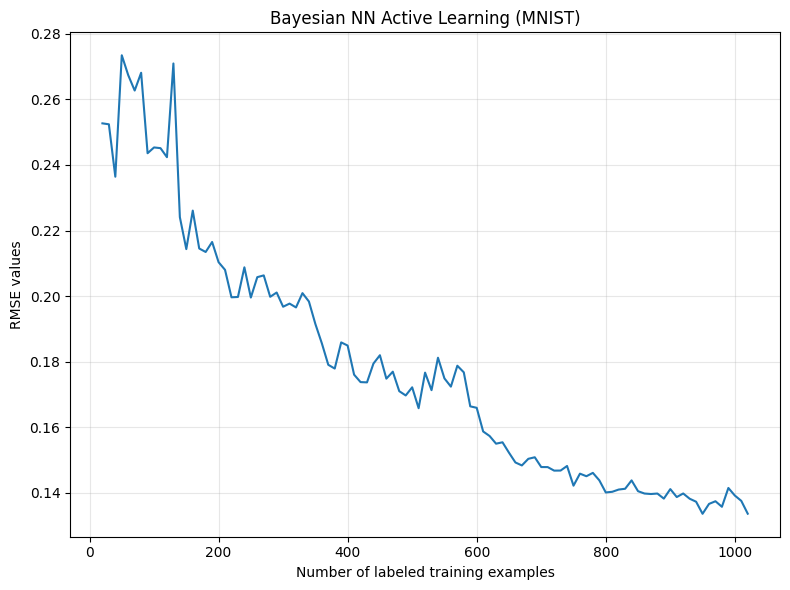

In [ ]:
# @title plot_active_learning_curves()
def plot_active_learning_curves(history_list, labels=None, ylim = None,
                                title="Bayesian NN Active Learning (MNIST)",
                                xlabel="Number of labeled training examples",
                                ylabel="RMSE values",
                                xfield="labelled_set_sizes",
                                yfield="test_rmse",
                                marker="",
                                linestyle="-"):
    if labels is not None:
        assert len(labels) == len(history_list), "Labels must have same length as history_list."

    plt.figure(figsize=(8, 6))

    for idx, history in enumerate(history_list):
        x = history[xfield]
        y = history[yfield]
        label = labels[idx] if labels is not None else None

        assert len(x) == len(y), "Label sizes and accuracies must have same length."
        plt.plot(x, y, marker=marker, linestyle=linestyle, label=label)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    if labels is not None:
        plt.legend()
    plt.show()

plot_active_learning_curves([history])

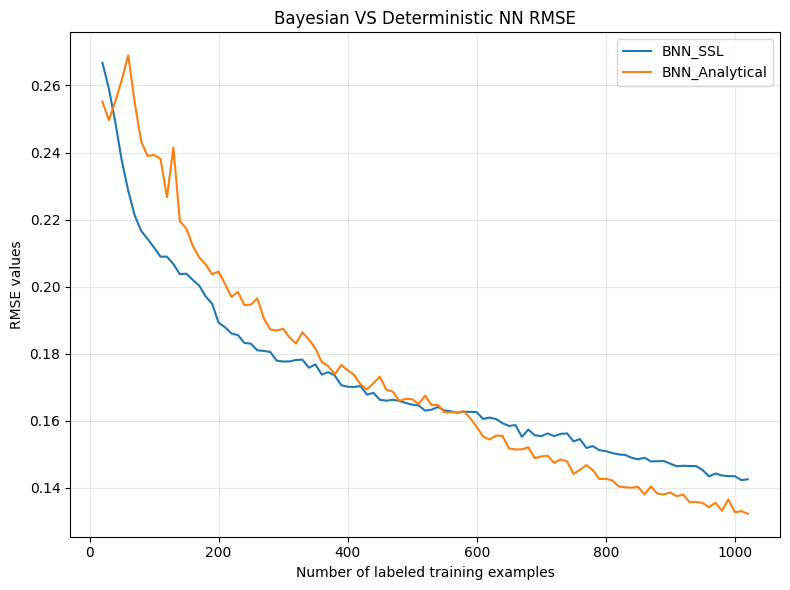

In [ ]:
model_names = ["BNN_Analytical", "BNN_SSL"]

file_names = ['outputs/bnn_analytical/history_BNN_Analytical_PredCovariance_AVG_STATS.json',
              'outputs/bnn_ssl/history_BNN_Analytical_PredCovariance_AVG_STATS.json']
history_list = []
for file_name in file_names:
    with open(file_name, 'r') as f:
        history = json.load(f)
        history_list.append(history)

plot_active_learning_curves(history_list, labels=model_names,
                            title=f"Bayesian VS Deterministic NN RMSE",
                            yfield="test_rmse_mean")